# Model experiments

In this notebook we will experiment with different models and different fitting and we will compare the results.

In [1]:
# Basic imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy import signal
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm
import pymannkendall as mk

from pandas.plotting import autocorrelation_plot


from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_predict

import itertools
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
path = "../data_postprocess/data_definitivo/"
path_bruto = "../data/"


## 1. Models on segmented variable 

We will start by fitting a model on one variable, which is the miscellaneous energy use in south wing (mels_S). In this first attempt, we will keep the segmented variable and all the samples, which means we have data from September 2018 until February 2019. One of the goals of this attempt is to decide wether we have enough data or if some upsampling will be necessary.

In [64]:
# Importamos csv
energy_use = pd.read_csv(path+'ele_postprocess.csv')
#We change the date column into datetime format
energy_use['date']= pd.to_datetime(energy_use['date'])
energy_use.set_index('date', inplace=True)
energy_use= energy_use.clip(lower=0.01)

start = '2018-09-15 10:00:00'
end = '2019-02-21 10:11:00'
energy_use = energy_use[(energy_use.index>=start)&(energy_use.index<=end)]


The first variable we will study is 'mels_S' (miscellaneous energy use in the south wing of the building).

In [65]:
var = 'mels_S'




### ARIMA 

We will fit a very basic ARIMA model into this variable, and we will study its behaviour. Since we have seasonality in our data, we will also use SARIMA and compare the results of fitting both models.
For this model, we have to decide the value of the main parameters:
- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

Also, the frequency we will consider is 672 samples, which is the same as one week.


In [66]:
#Split into train and test:

df_train = energy_use.iloc[:-2000,:][var]
df_test = energy_use.iloc[-2000:, :][var]

In [67]:
import warnings
warnings.filterwarnings("ignore")

First, we will implement a model that has as a train set 75% of the whole set, and forecasts the next 25% of the samples in one single take.


In [68]:
model_arima_inicial = ARIMA(df_train, order =(1,2,2))
model_arima_inicial_fit = model_arima_inicial.fit()
print(model_arima_inicial_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                 mels_S   No. Observations:                14790
Model:                 ARIMA(1, 2, 2)   Log Likelihood                2997.817
Date:                Mon, 28 Nov 2022   AIC                          -5987.633
Time:                        19:54:17   BIC                          -5957.227
Sample:                             0   HQIC                         -5977.538
                              - 14790                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8084      0.005    154.956      0.000       0.798       0.819
ma.L1         -1.4722      0.015    -99.451      0.000      -1.501      -1.443
ma.L2          0.4723      0.009     51.876      0.0

Next, we will plot the residuals (necessary to check if there are patterns):


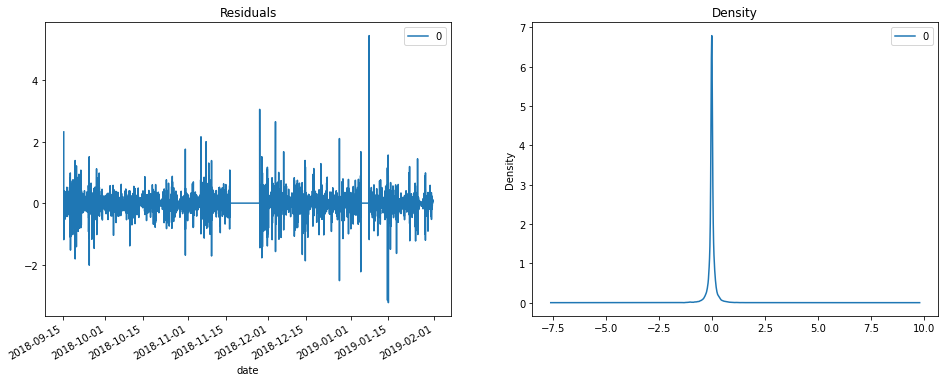

In [69]:
# Plot residual errors
residuals = pd.DataFrame(model_arima_inicial_fit.resid)
fig, ax= plt.subplots(nrows=1,ncols=2, figsize=(16,6) )
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

We want to plot the predictions of the model starting for the test set. We will also check if a dynamic forecasting works better than static one.

In [70]:
df_test.shape[0]

2000

In [71]:
energy_use.iloc[-(df_test.shape[0]-1000):,:]

mels_S     lig_S     mels_N     hvac_N     hvac_S
date                                                                    
2019-02-11 00:15:00  1.657143  0.100000   9.700000   3.005882   0.010000
2019-02-11 00:30:00  1.700000  0.060000  10.333333   9.282632   0.010000
2019-02-11 00:45:00  1.500000  0.083333   9.996667  16.373846   5.027857
2019-02-11 01:00:00  1.300000  0.050000   9.813333  15.434375   0.010000
2019-02-11 01:15:00  1.500000  0.020000  10.200000  18.754737  11.082632
...                       ...       ...        ...        ...        ...
2019-02-21 09:00:00  2.173077  0.200000   8.638000   7.864500  22.789474
2019-02-21 09:15:00  2.187692  0.133333   8.292500  10.214737  22.079500
2019-02-21 09:30:00  2.202308  0.150000   8.650000  10.322353  26.047059
2019-02-21 09:45:00  2.216923  0.200000   8.250000  12.510588  24.731250
2019-02-21 10:00:00  2.231538  0.175000   8.778000   8.475882  22.681250

[1000 rows x 5 columns]

In [5]:
def plot_zoom(model_fit, df, df_test, var):
    plt.figure(figsize=(16, 10))
    predictions = model_fit.forecast(len(df_test), dynamic=True)
    predictions.index = df_test.index
    df.iloc[-(df_test.shape[0]+1000):,:][var].plot(label='true values')
    predictions.plot(label='predicted values')
    plt.legend()

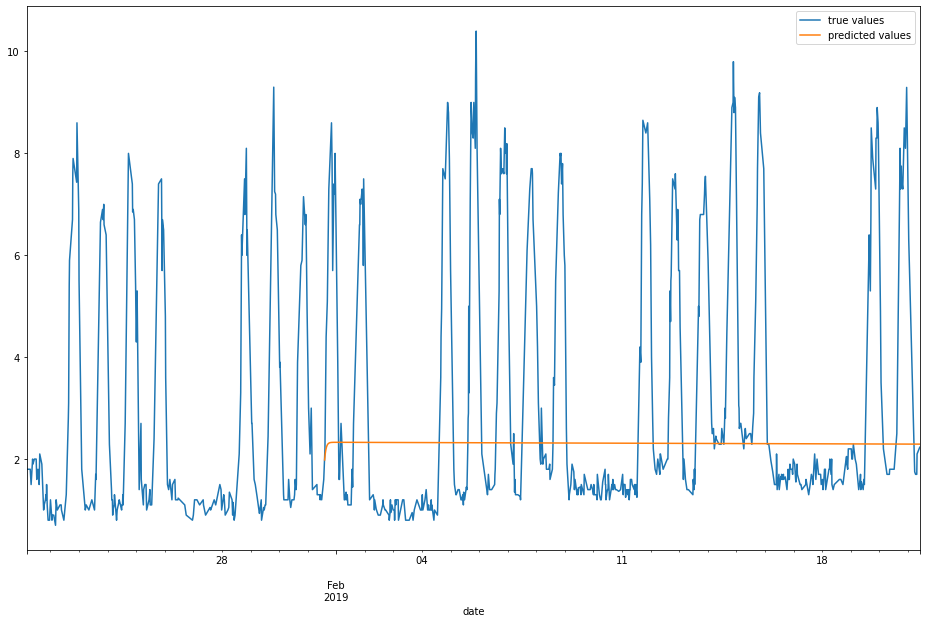

In [73]:
plot_zoom(model_arima_inicial_fit, energy_use, df_test, var)

We see that the model is not performing well. This can be due to the current train-test split. We are going to add some more samples to the test set so that the end of the train set doesn't end in the constant line that we can see in the plot. 

                               SARIMAX Results                                
Dep. Variable:                 mels_S   No. Observations:                14290
Model:                 ARIMA(1, 2, 2)   Log Likelihood                2807.022
Date:                Mon, 28 Nov 2022   AIC                          -5606.044
Time:                        19:54:31   BIC                          -5575.776
Sample:                             0   HQIC                         -5595.978
                              - 14290                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8091      0.005    151.284      0.000       0.799       0.820
ma.L1         -1.4763      0.008   -182.240      0.000      -1.492      -1.460
ma.L2          0.4763      0.007     70.775      0.0

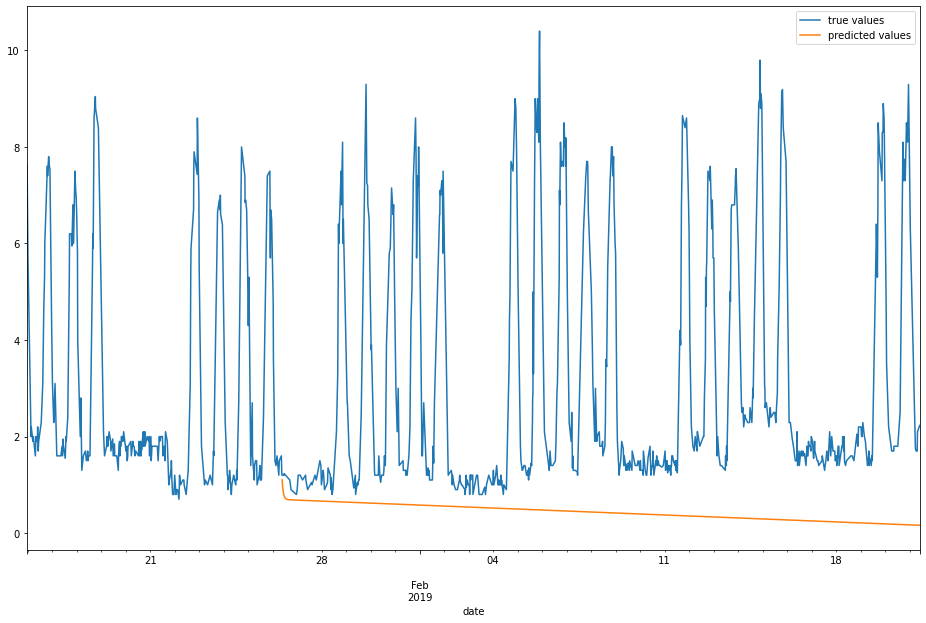

In [74]:
#Split into train and test:

df_train_2 = energy_use.iloc[:-2500,:][var]
df_test_2 = energy_use.iloc[-2500:, :][var]

model_arima_2 = ARIMA(df_train_2, order =(1,2,2))
model_arima_2_fit = model_arima_2.fit()
print(model_arima_2_fit.summary())

plot_zoom(model_arima_2_fit,energy_use, df_test_2, var)

The problem was not the split, the behaviour of the model is still very bad.

In [75]:
start = df_train_2.index[10000]
end = df_train_2.index[-1]


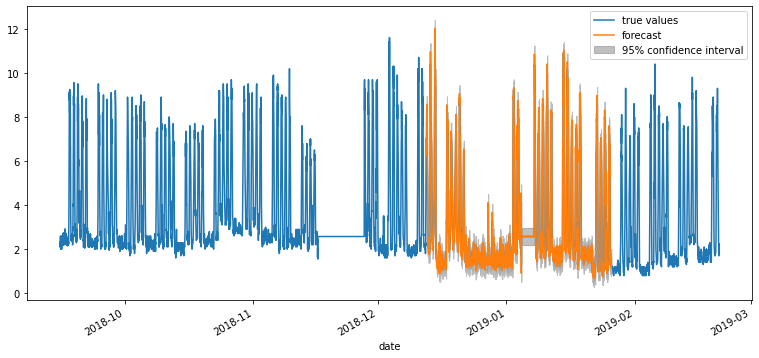

In [76]:
# Actual vs Fitte
fig, ax = plt.subplots(figsize=(13,6))

ax = energy_use[var].plot(label ='true values', ax=ax)

fig = plot_predict(model_arima_2_fit, start = start, end = end, ax = ax)
#ax.set_xlim(['2019-01', '2019-02'])
plt.show()

##### Evaluation metrics

We will check the train and test evaluation metrics: MAE (Mean Absolute Error), MAPE (Mean Absolute Percentage Error), and RMSE (Root Mean Squared Error). As we have seen in previous plots, the behaviour in train and test sets is very different:

In [77]:
print("TRAIN SET METRICS")
train_forecast = model_arima_inicial_fit.predict(start=df_train.index[0], end=df_train.index[-1])
mae = mean_absolute_error(df_train, train_forecast)
mape = mean_absolute_percentage_error(df_train, train_forecast)
rmse = np.sqrt(mean_squared_error(df_train, train_forecast))

print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

TRAIN SET METRICS
mae: 0.09183735881184808
mape: 0.02748368845490793
rmse: 0.1987280943413293


In [78]:
print("TEST SET METRICS")
test_forecast = model_arima_inicial_fit.forecast(len(df_test))
mae = mean_absolute_error(df_test, test_forecast)
mape = mean_absolute_percentage_error(df_test, test_forecast)
rmse = np.sqrt(mean_squared_error(df_test, test_forecast))

print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

TEST SET METRICS
mae: 1.818379249682862
mape: 0.5709861778662234
rmse: 2.6135113151179947


In [4]:
#We create a function because we are going to use this two cells in all the models that we train

def metrics(model_fit, df_test, df_train):
    print("TRAIN SET METRICS")
    train_forecast = model_fit.predict(start=df_train.index[0], end=df_train.index[-1])
    mae = mean_absolute_error(df_train, train_forecast)
    mape = mean_absolute_percentage_error(df_train, train_forecast)
    rmse = np.sqrt(mean_squared_error(df_train, train_forecast))

    print(f'mae: {mae}')
    print(f'mape: {mape}')
    print(f'rmse: {rmse}')

    print("TEST SET METRICS")
    test_forecast = model_fit.forecast(len(df_test))
    mae = mean_absolute_error(df_test, test_forecast)
    mape = mean_absolute_percentage_error(df_test, test_forecast)
    rmse = np.sqrt(mean_squared_error(df_test, test_forecast))

    print(f'mae: {mae}')
    print(f'mape: {mape}')
    print(f'rmse: {rmse}')


Clearly, we have overfitting, this means that the model is not able to correctly predict outside of the training set.

#### Parameter tuning
Even if we didn't acheive great results with ARIMA, we will try to tune the parameters, comparing models with the AIC and BIC metrics:

In [ ]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(0, 3):

  for d in range(0,3):
  # Loop over q values from 0-2
    for q in range(0, 3):
        print("Model: \np=", p,"\nd=", d, "\nq=", q)
      	# create and fit ARMA(p,q) model
        model = ARIMA(df_train, order=(p,d,q))
        results = model.fit()
        
        # Append order and results tuple
        order_aic_bic.append((p, d, q, results.aic, results.bic))

Model: 
p= 0 
d= 0 
q= 0
Model: 
p= 0 
d= 0 
q= 1
Model: 
p= 0 
d= 0 
q= 2
Model: 
p= 0 
d= 1 
q= 0
Model: 
p= 0 
d= 1 
q= 1
Model: 
p= 0 
d= 1 
q= 2
Model: 
p= 0 
d= 2 
q= 0
Model: 
p= 0 
d= 2 
q= 1
Model: 
p= 0 
d= 2 
q= 2
Model: 
p= 1 
d= 0 
q= 0
Model: 
p= 1 
d= 0 
q= 1
Model: 
p= 1 
d= 0 
q= 2
Model: 
p= 1 
d= 1 
q= 0
Model: 
p= 1 
d= 1 
q= 1
Model: 
p= 1 
d= 1 
q= 2
Model: 
p= 1 
d= 2 
q= 0
Model: 
p= 1 
d= 2 
q= 1
Model: 
p= 1 
d= 2 
q= 2
Model: 
p= 2 
d= 0 
q= 0
Model: 
p= 2 
d= 0 
q= 1
Model: 
p= 2 
d= 0 
q= 2
Model: 
p= 2 
d= 1 
q= 0
Model: 
p= 2 
d= 1 
q= 1
Model: 
p= 2 
d= 1 
q= 2
Model: 
p= 2 
d= 2 
q= 0
Model: 
p= 2 
d= 2 
q= 1
Model: 
p= 2 
d= 2 
q= 2


In [ ]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','d','q','AIC','BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values(by='AIC', ascending=True))



    p  d  q           AIC           BIC
19  2  0  1  -3390.716121  -3352.879545
20  2  0  2  -3390.003540  -3344.599649
22  2  1  1  -3135.046414  -3104.777433
14  1  1  2  -3134.602164  -3104.333183
23  2  1  2  -3133.976608  -3096.140382
13  1  1  1  -3133.559816  -3110.858080
17  1  2  2  -3122.602987  -3092.334286
26  2  2  2  -2861.692430  -2823.856553
21  2  1  0  -2818.131870  -2795.430134
25  2  2  1  -2682.207668  -2651.938967
16  1  2  1  -2578.616244  -2555.914718
8   0  2  2  -2572.785274  -2550.083748
7   0  2  1  -2550.215565  -2535.081214
11  1  0  2  -2378.359068  -2340.522492
5   0  1  2  -2320.746357  -2298.044621
18  2  0  0  -2159.124291  -2128.855030
12  1  1  0  -2097.656271  -2082.521780
10  1  0  1  -1705.524525  -1675.255264
4   0  1  1  -1662.368692  -1647.234202
24  2  2  0  -1013.297637   -990.596111
9   1  0  0   -755.964267   -733.262321
3   0  1  0   -726.954320   -719.387074
15  1  2  0     45.178225     60.312575
6   0  2  0   4027.188808   4034.755984


In [ ]:
print(order_df.sort_values(by='BIC', ascending=True))


    p  d  q            AIC            BIC
20  2  0  2   12141.024916   12190.451374
19  2  0  1   12311.840279   12353.028995
14  1  1  2   12781.752486   12814.703315
23  2  1  2   12781.295091   12822.483628
22  2  1  1   12795.378846   12828.329675
13  1  1  1   13036.575775   13061.288897
25  2  2  1   13843.185994   13876.136679
16  1  2  1   13856.874796   13881.587811
17  1  2  2   13854.327222   13887.277908
8   0  2  2   13863.749735   13888.462749
26  2  2  2   13860.202764   13901.391121
21  2  1  0   13897.144092   13921.857214
7   0  2  1   13953.723421   13970.198764
11  1  0  2   14127.837033   14169.025749
5   0  1  2   14284.054411   14308.767532
18  2  0  0   14685.077858   14718.028830
12  1  1  0   14826.969432   14843.444847
10  1  0  1   14814.418808   14847.369780
4   0  1  1   14943.662465   14960.137879
9   1  0  0   15173.721190   15198.434419
3   0  1  0   15281.013519   15289.251226
24  2  2  0   17458.338801   17483.051816
15  1  2  0   21279.425193   21295

We will repeat previous steps with ARIMA(2,0,2)

                               SARIMAX Results                                
Dep. Variable:                 mels_S   No. Observations:                14290
Model:                 ARIMA(2, 0, 2)   Log Likelihood                1701.002
Date:                Mon, 07 Nov 2022   AIC                          -3390.004
Time:                        10:51:44   BIC                          -3344.600
Sample:                             0   HQIC                         -3374.903
                              - 14290                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2208      0.148     21.791      0.000       2.931       3.510
ar.L1          1.9172      0.004    461.938      0.000       1.909       1.925
ar.L2         -0.9207      0.004   -222.159      0.0

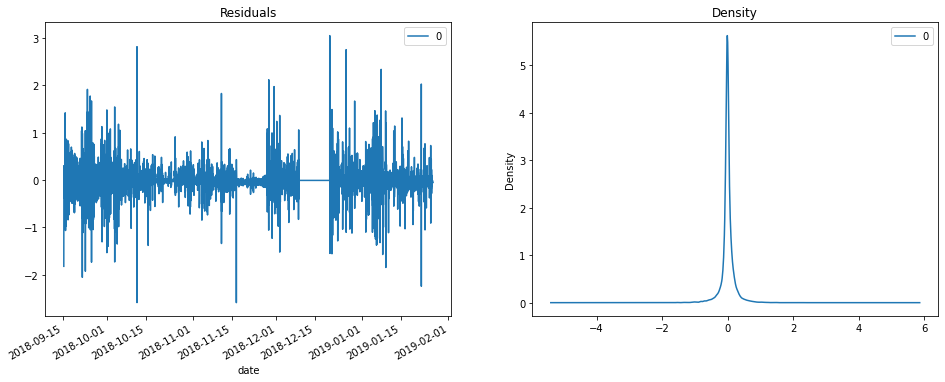

TRAIN SET METRICS
mae - manual: 0.10967899337017521
mape - manual: 0.24420831944521354
rmse - manual: 0.21531335731664203
TEST SET METRICS
mae - manual: 1.8912260754357852
mape - manual: 0.7483375291685317
rmse - manual: 2.355403454359788


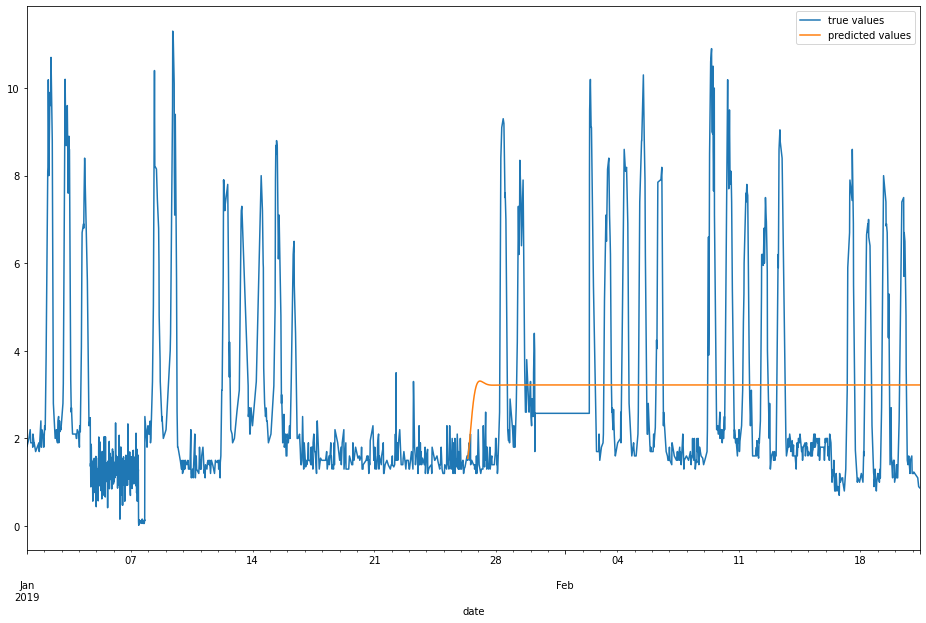

In [ ]:
model_arima_tuned = ARIMA(df_train, order =(2,0,2))
model_arima_tuned_fit = model.fit()
print(model_arima_tuned_fit.summary())


# Plot residual errors
residuals = pd.DataFrame(model_arima_tuned_fit.resid)
fig, ax= plt.subplots(nrows=1,ncols=2, figsize=(16,6) )
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

plot_zoom(model_arima_tuned_fit, energy_use, df_test, var)
metrics(model_arima_tuned_fit, df_test, df_train)




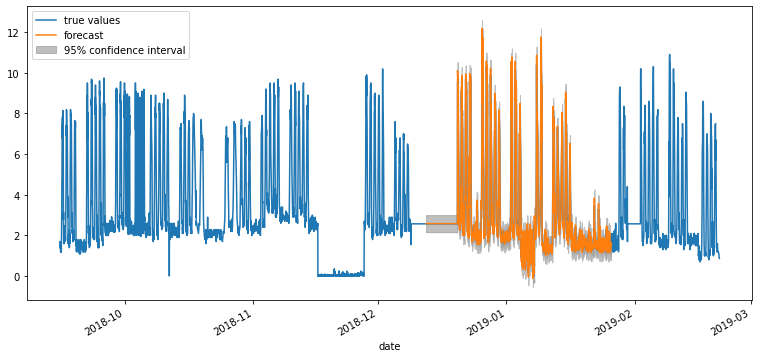

In [ ]:
# Actual vs Fitte
fig, ax = plt.subplots(figsize=(13,6))

ax = energy_use[var].plot(label ='true values', ax=ax)

fig = plot_predict(model_arima_tuned_fit, start = start, end = end, ax = ax)
#ax.set_xlim(['2019-01', '2019-02'])
plt.show()

### SARIMAX
Even though our variable is stationary, we are going to fit a sarimax model and check the accuracy of its forecasts.

In [ ]:
sarimax_mod = sm.tsa.statespace.SARIMAX(energy_use[var],order=(2,0,2),
                                                seasonal_order=(2,0,2,12),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

sarimax_fit = sarimax_mod.fit(maxiter=50) 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.35379D+02    |proj g|=  1.00765D+05


 This problem is unconstrained.



At iterate    5    f=  6.13291D-01    |proj g|=  1.59669D+00

At iterate   10    f=  7.14515D-02    |proj g|=  1.41713D+00

At iterate   15    f= -2.71863D-02    |proj g|=  2.42645D-01

At iterate   20    f= -8.71429D-02    |proj g|=  2.94122D+00

At iterate   25    f= -9.21615D-02    |proj g|=  1.02135D-01

At iterate   30    f= -9.21764D-02    |proj g|=  7.72631D-02

At iterate   35    f= -9.24465D-02    |proj g|=  8.73125D-02

At iterate   40    f= -9.28856D-02    |proj g|=  1.71341D-02

At iterate   45    f= -9.37496D-02    |proj g|=  1.40908D-01

At iterate   50    f= -9.37570D-02    |proj g|=  1.03140D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

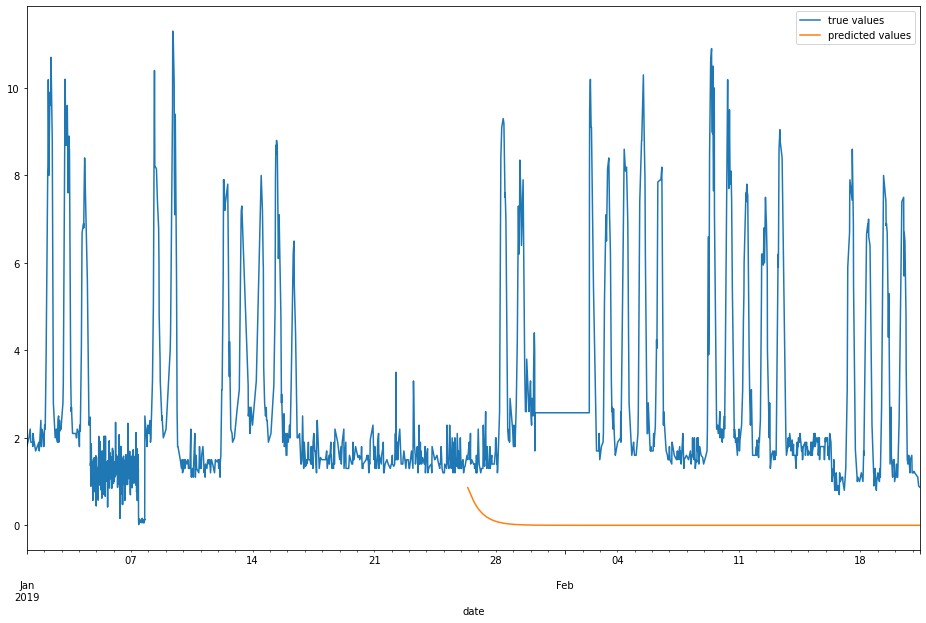

In [ ]:
plot_zoom(sarimax_fit, energy_use, df_test, var)

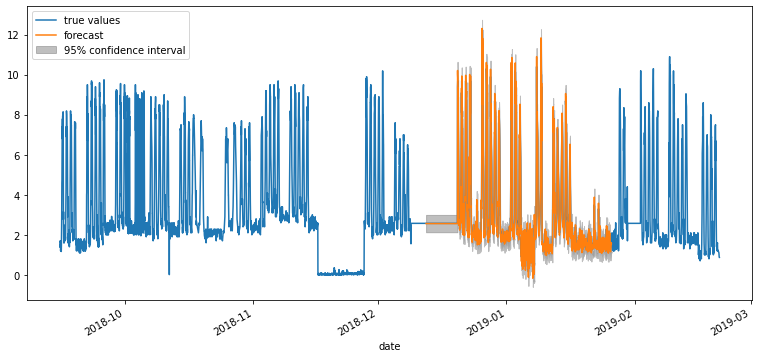

In [ ]:

# Actual vs Fitte
fig, ax = plt.subplots(figsize=(13,6))

ax = energy_use[var].plot(label ='true values', ax=ax)

fig = plot_predict(sarimax_fit, start = start, end = end, ax = ax)
#ax.set_xlim(['2019-01', '2019-02'])
plt.legend()
plt.show()

Next, we will compare the MSE of both models:

In [ ]:
metrics(sarimax_fit, df_test, df_train)

TRAIN SET METRICS
mae: 0.10816472551880453
mape: 0.16245201817463184
rmse: 0.2169975239627378
TEST SET METRICS
mae: 3.157640561728837
mape: 0.9845260330978169
rmse: 3.95219855246677


### Prophet
We will try a very simple model and check if we still have overfitting:

In [ ]:
from prophet import Prophet
df_train_p = df_train.reset_index()
df_train_p.columns=['ds', 'y']
df_test_p = df_test.reset_index()
df_test_p.columns=['ds', 'y']

In [ ]:
model = Prophet()
model.fit(df_train_p)

11:16:55 - cmdstanpy - INFO - Chain [1] start processing
11:16:58 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
#Out of sample forecast
future = df_test_p[['ds']]
forecast = model.predict(future)

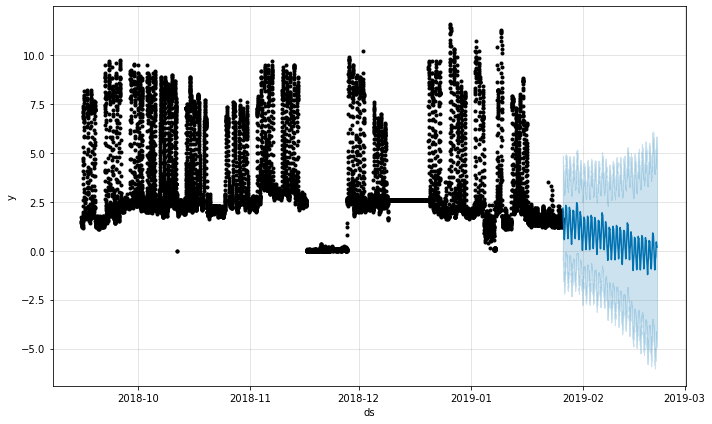

In [ ]:
fig1 = model.plot(forecast)


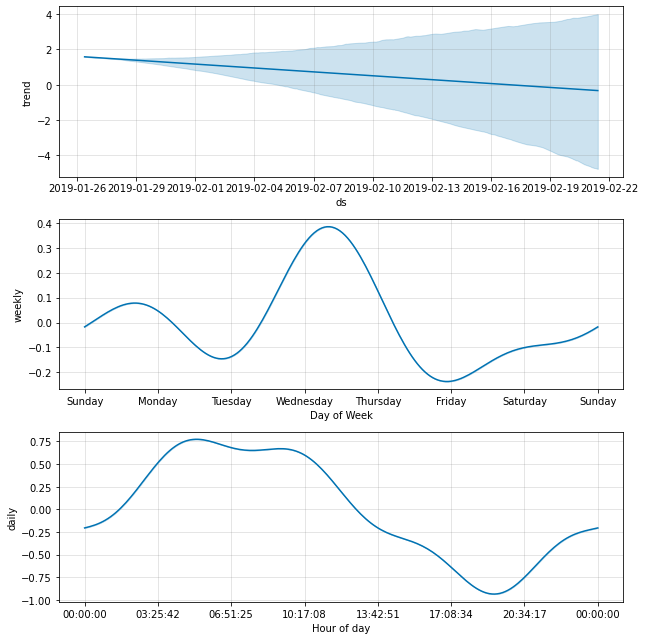

In [ ]:
fig2 = model.plot_components(forecast)


In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

Next, we will check the in sample predictions


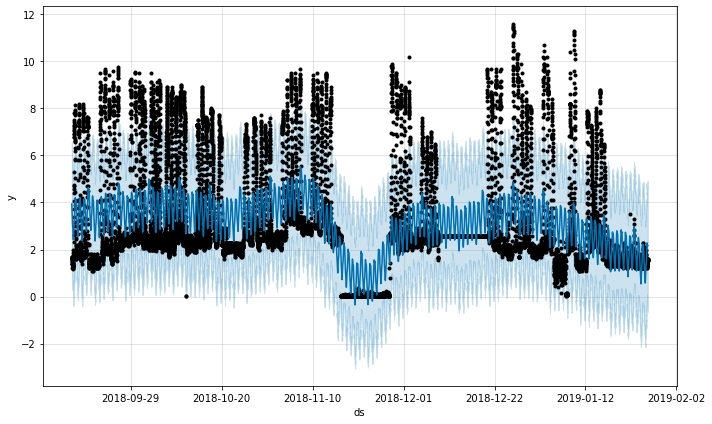

In [ ]:
#Out of sample forecast
future = df_train_p[['ds']]
forecast = model.predict(future)
fig1 = model.plot(forecast)


We see that it picks up some of the movement of the time series, but not really, since it doesn't model all the peaks.

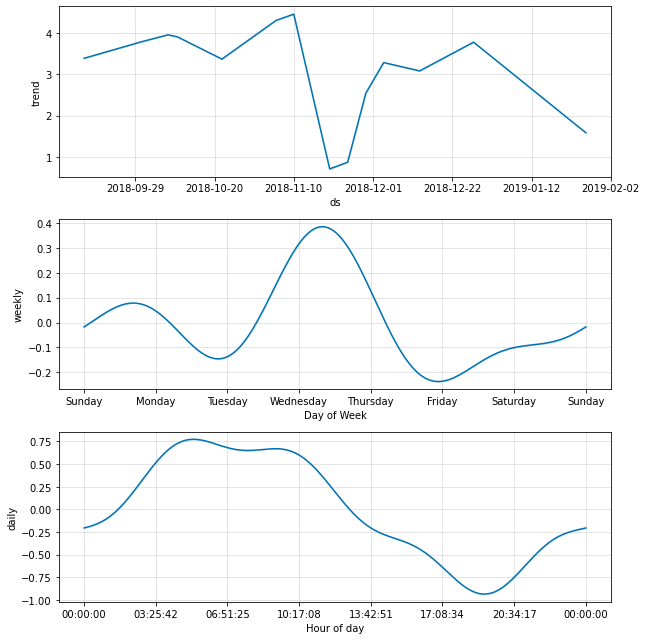

In [ ]:
fig2 = model.plot_components(forecast)


Now we will repeat some of the plots we had with previous models, so we can compare them:


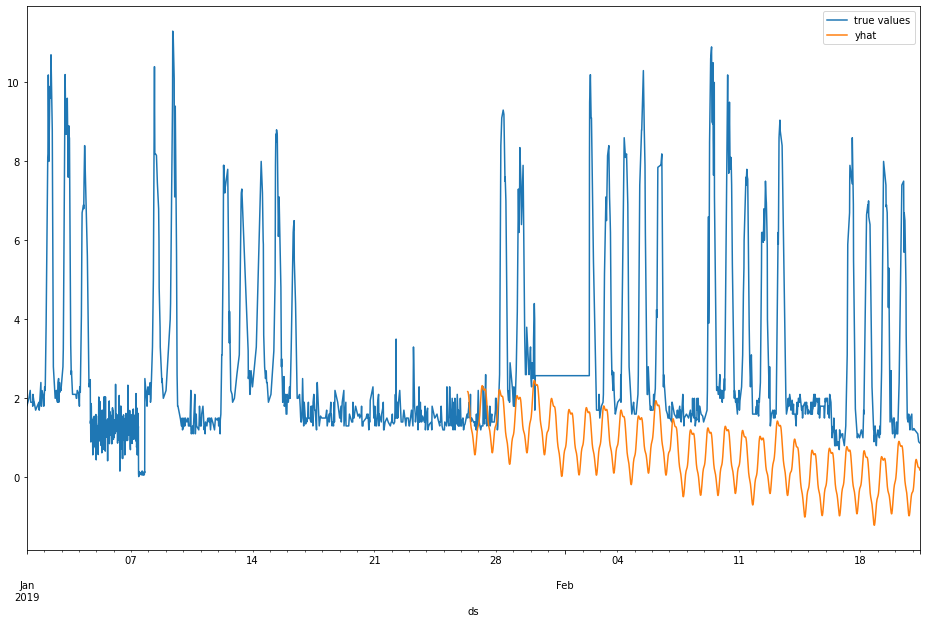

In [ ]:
plt.figure(figsize=(16, 10))
df = energy_use
#Out of sample forecast
future = df_test_p[['ds']]
forecast = model.predict(future)[['ds', 'yhat']].set_index('ds')
ax = df[df.index.month.isin([1,2])][var].plot(label='true values')
forecast.plot(label='predicted values', ax=ax)
plt.legend()

## 2. Models on full variable 

Since fitting the model on the segmented variable did not work well, we are going to compare the behaviour of the same models, except this time we are fitting them on the full variable.

In [2]:
# Importamos csv
energy_use = pd.read_csv(path+'ele_postprocess.csv')
#We change the date column into datetime format
energy_use['date']= pd.to_datetime(energy_use['date'])
energy_use.set_index('date', inplace=True)
energy_use= energy_use.clip(lower=0.01)

energy_use=energy_use[energy_use.index <'2020-03-01 00:00:00']

The first variable we will study is 'mels_S' (miscellaneous energy use in the south wing of the building).

In [3]:
var = 'mels_S'

Text(0.5, 1.0, 'Energía utilizada en el ala sur')

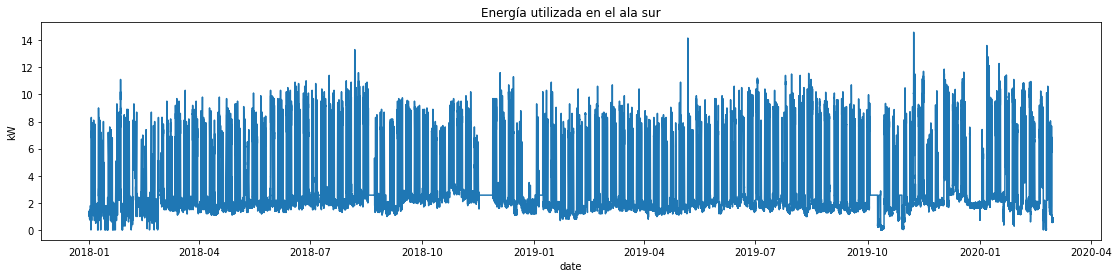

In [81]:
plt.figure(figsize=(19,4))
sns.lineplot(x =energy_use.index , y=energy_use[var])
plt.ylabel('kW')

plt.title('Energía utilizada en el ala sur')




## ARIMA 

We will fit a very basic ARIMA model into this variable, and we will study its behaviour. Since we have seasonality in our data, we will also use SARIMA and compare the results of fitting both models.
For this model, we have to decide the value of the main parameters:
- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

Also, the frequency we will consider is 672 samples, which is the same as one week.


In [8]:
#Split into train and test: 2020 will be our test set

df_train_full = energy_use[energy_use.index.year<2020][var]
df_test_full = energy_use[energy_use.index.year==2020][var]

In [9]:
df_train_full.shape

(71601,)

In [10]:
df_test_full.shape

(5760,)

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [85]:
arima_full = ARIMA(df_train_full, order =(1,2,2))
arima_full_fit = arima_full.fit()
print(arima_full_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                 mels_S   No. Observations:                71601
Model:                 ARIMA(1, 2, 2)   Log Likelihood              -22992.183
Date:                Mon, 28 Nov 2022   AIC                          45992.366
Time:                        19:56:36   BIC                          46029.082
Sample:                             0   HQIC                         46003.678
                              - 71601                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0023      0.023      0.098      0.922      -0.043       0.048
ma.L1         -0.9140      0.023    -39.269      0.000      -0.960      -0.868
ma.L2          0.0530      0.020      2.601      0.0

Next, we will plot the residuals (necessary to check if there are patterns):


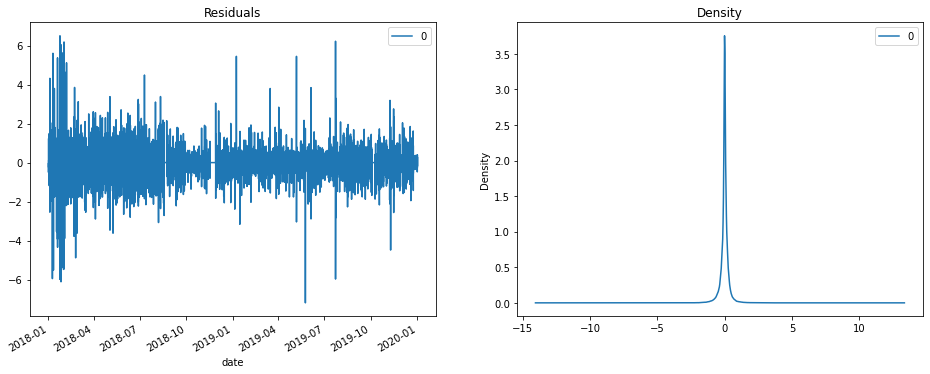

In [86]:
# Plot residual errors
residuals = pd.DataFrame(arima_full_fit.resid)
fig, ax= plt.subplots(nrows=1,ncols=2, figsize=(16,6) )
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

We want to plot the predictions of the model starting for the test set. We will also check if a dynamic forecasting works better than static one.

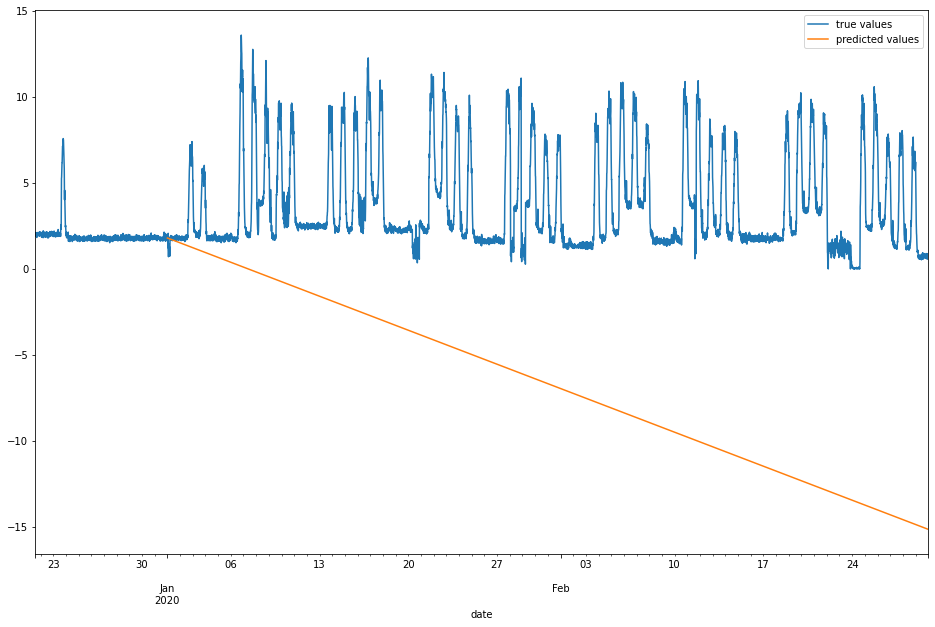

In [87]:
plot_zoom(arima_full_fit, energy_use, df_test_full, var)

In [90]:
start = df_train.index[6000]
end = df_train.index[-1]


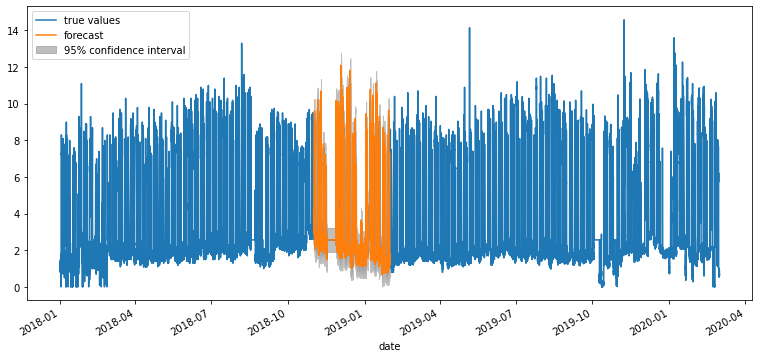

In [92]:
# Actual vs Fitte
fig, ax = plt.subplots(figsize=(13,6))

ax = energy_use[var].plot(label ='true values', ax=ax)

fig = plot_predict(arima_full_fit, start = start, end = end, ax = ax)
#ax.set_xlim(['2019-01', '2019-02'])
plt.show()

#### Evaluation metrics

We will check the train and test evaluation metrics: MAE (Mean Absolute Error), MAPE (Mean Absolute Percentage Error), and RMSE (Root Mean Squared Error). As we have seen in previous plots, the behaviour in train and test sets is very different:

In [93]:
metrics(arima_full_fit, df_test_full, df_train_full)

TRAIN SET METRICS
mae: 0.17589185838555338
mape: 0.09073387192824846
rmse: 0.33362804645041994
TEST SET METRICS
mae: 10.364188117044083
mape: 9.65391637069958
rmse: 11.726352447533678


Clearly, we have overfitting, this means that the model is not able to correctly predict outside of the training set.

#### Parameter tuning
Even if we didn't acheive great results with ARIMA, we will try to tune the parameters, comparing models with the AIC and BIC metrics:

In [66]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(0, 3):

  for d in range(0,3):
  # Loop over q values from 0-2
    for q in range(0, 3):
        print("Model: \np=", p,"\nd=", d, "\nq=", q)
      	# create and fit ARMA(p,q) model
        model = ARIMA(df_train_full, order=(p,d,q))
        results = model.fit()
        
        # Append order and results tuple
        order_aic_bic.append((p, d, q, results.aic, results.bic))

Model: 
p= 0 
d= 0 
q= 0
Model: 
p= 0 
d= 0 
q= 1
Model: 
p= 0 
d= 0 
q= 2
Model: 
p= 0 
d= 1 
q= 0
Model: 
p= 0 
d= 1 
q= 1
Model: 
p= 0 
d= 1 
q= 2
Model: 
p= 0 
d= 2 
q= 0
Model: 
p= 0 
d= 2 
q= 1
Model: 
p= 0 
d= 2 
q= 2
Model: 
p= 1 
d= 0 
q= 0
Model: 
p= 1 
d= 0 
q= 1
Model: 
p= 1 
d= 0 
q= 2
Model: 
p= 1 
d= 1 
q= 0
Model: 
p= 1 
d= 1 
q= 1
Model: 
p= 1 
d= 1 
q= 2
Model: 
p= 1 
d= 2 
q= 0
Model: 
p= 1 
d= 2 
q= 1
Model: 
p= 1 
d= 2 
q= 2
Model: 
p= 2 
d= 0 
q= 0
Model: 
p= 2 
d= 0 
q= 1
Model: 
p= 2 
d= 0 
q= 2
Model: 
p= 2 
d= 1 
q= 0
Model: 
p= 2 
d= 1 
q= 1
Model: 
p= 2 
d= 1 
q= 2
Model: 
p= 2 
d= 2 
q= 0
Model: 
p= 2 
d= 2 
q= 1
Model: 
p= 2 
d= 2 
q= 2


In [67]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','d','q','AIC','BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values(by='AIC', ascending=True))



    p  d  q            AIC            BIC
20  2  0  2   41221.400341   41276.473527
19  2  0  1   41577.741782   41623.636104
23  2  1  2   43348.915707   43394.809959
14  1  1  2   43482.705586   43519.420988
22  2  1  1   43521.635679   43558.351080
13  1  1  1   43894.753200   43922.289751
26  2  2  2   45976.381527   46022.275709
25  2  2  1   45990.113990   46026.829336
8   0  2  2   45990.368320   46017.904829
16  1  2  1   45991.863769   46019.400278
17  1  2  2   45992.366310   46029.081655
7   0  2  1   46156.290733   46174.648406
21  2  1  0   46475.526976   46503.063527
11  1  0  2   46706.348004   46752.242326
5   0  1  2   47195.388495   47222.925046
18  2  0  0   47559.764821   47596.480278
10  1  0  1   47825.738292   47862.453749
12  1  1  0   48012.238220   48030.595920
4   0  1  1   48244.722560   48263.080261
9   1  0  0   48734.692805   48762.229398
3   0  1  0   49084.895981   49094.074831
24  2  2  0   56989.610050   57017.146560
15  1  2  0   66744.227850   66762

In [68]:
print(order_df.sort_values(by='BIC', ascending=True))


    p  d  q            AIC            BIC
20  2  0  2   41221.400341   41276.473527
19  2  0  1   41577.741782   41623.636104
23  2  1  2   43348.915707   43394.809959
14  1  1  2   43482.705586   43519.420988
22  2  1  1   43521.635679   43558.351080
13  1  1  1   43894.753200   43922.289751
8   0  2  2   45990.368320   46017.904829
16  1  2  1   45991.863769   46019.400278
26  2  2  2   45976.381527   46022.275709
25  2  2  1   45990.113990   46026.829336
17  1  2  2   45992.366310   46029.081655
7   0  2  1   46156.290733   46174.648406
21  2  1  0   46475.526976   46503.063527
11  1  0  2   46706.348004   46752.242326
5   0  1  2   47195.388495   47222.925046
18  2  0  0   47559.764821   47596.480278
10  1  0  1   47825.738292   47862.453749
12  1  1  0   48012.238220   48030.595920
4   0  1  1   48244.722560   48263.080261
9   1  0  0   48734.692805   48762.229398
3   0  1  0   49084.895981   49094.074831
24  2  2  0   56989.610050   57017.146560
15  1  2  0   66744.227850   66762

We will repeat previous steps with ARIMA(2,0,2)

                               SARIMAX Results                                
Dep. Variable:                 mels_S   No. Observations:                75361
Model:                 ARIMA(1, 2, 2)   Log Likelihood              -25400.690
Date:                Mon, 28 Nov 2022   AIC                          50809.381
Time:                        19:57:49   BIC                          50846.301
Sample:                             0   HQIC                         50820.729
                              - 75361                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0255      0.024      1.073      0.283      -0.021       0.072
ma.L1         -0.9384      0.024    -39.403      0.000      -0.985      -0.892
ma.L2          0.0727      0.021      3.482      0.0

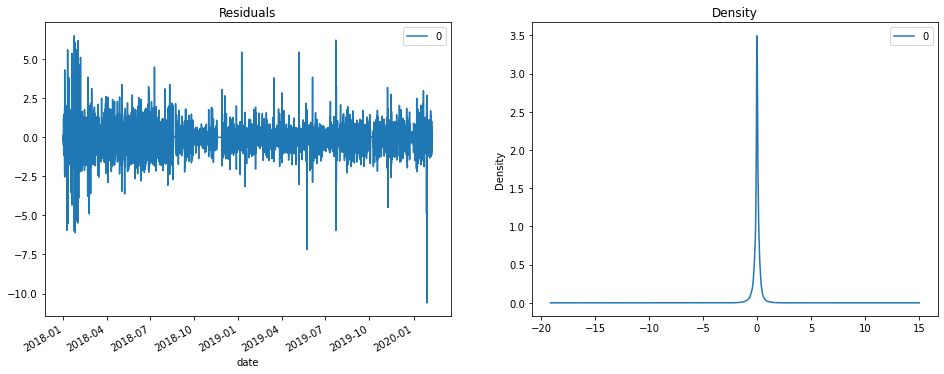

TRAIN SET METRICS
mae: 0.1760256619005799
mape: 0.09076040355951204
rmse: 0.33363016304125265
TEST SET METRICS
mae: 2.186013277100955
mape: 2.4836165460441135
rmse: 3.005730588870054


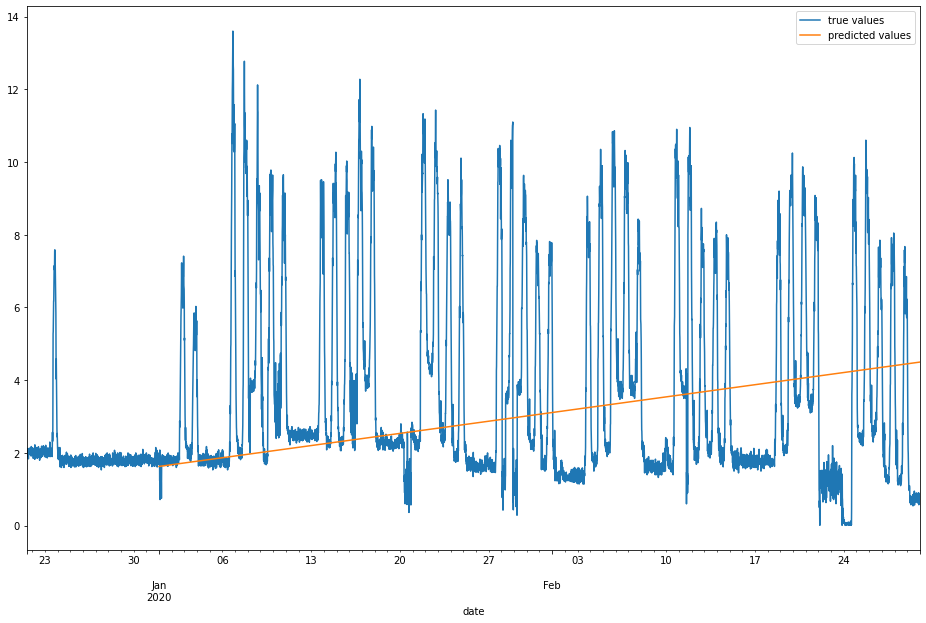

In [94]:
arima_tuned = ARIMA(df_train_full, order =(2,0,2))
arima_tuned_fit = model.fit()
print(arima_tuned_fit.summary())


# Plot residual errors
residuals = pd.DataFrame(arima_tuned_fit.resid)
fig, ax= plt.subplots(nrows=1,ncols=2, figsize=(16,6) )
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

plot_zoom(arima_tuned_fit, energy_use, df_test_full, var)
metrics(arima_tuned_fit, df_test_full, df_train_full)




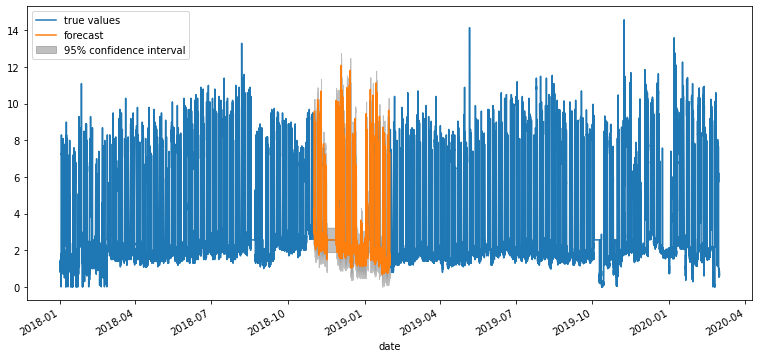

In [95]:
# Actual vs Fitte
fig, ax = plt.subplots(figsize=(13,6))

ax = energy_use[var].plot(label ='true values', ax=ax)

fig = plot_predict(arima_tuned_fit, start = start, end = end, ax = ax)
#ax.set_xlim(['2019-01', '2019-02'])
plt.show()

### SARIMAX
Even though our variable is stationary, we are going to fit a sarimax model and check the accuracy of its forecasts.

In [8]:
sarimax_full = sm.tsa.statespace.SARIMAX(energy_use[var],order=(2,0,2),
                                                seasonal_order=(2,0,2,12),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

sarimax_full_fit = sarimax_full.fit(maxiter=50) 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57319D+00    |proj g|=  2.38759D+01

At iterate    5    f=  1.22452D+00    |proj g|=  3.37440D+00

At iterate   10    f=  5.90425D-01    |proj g|=  8.78811D-01

At iterate   15    f=  3.50082D-01    |proj g|=  3.38516D-01

At iterate   20    f=  3.26155D-01    |proj g|=  1.05723D-01

At iterate   25    f=  3.24021D-01    |proj g|=  5.43934D-02

At iterate   30    f=  3.21883D-01    |proj g|=  8.58242D-02

At iterate   35    f=  3.21730D-01    |proj g|=  4.62955D-01

At iterate   40    f=  3.20790D-01    |proj g|=  1.52688D-01

At iterate   45    f=  3.20515D-01    |proj g|=  4.38319D-02

At iterate   50    f=  3.20507D-01    |proj g|=  2.87821D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

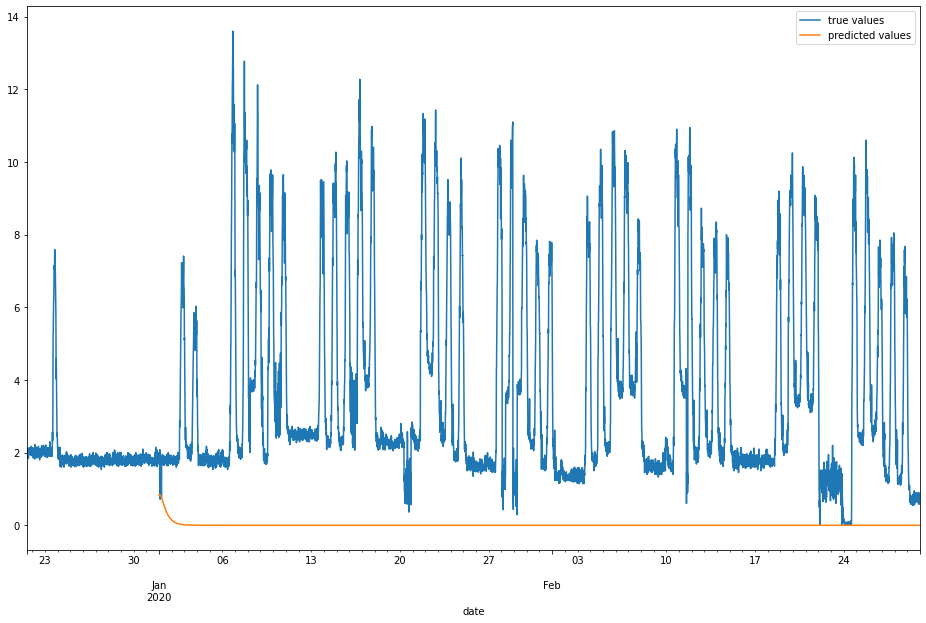

In [96]:
plot_zoom(sarimax_fit, energy_use, df_test_full, var)

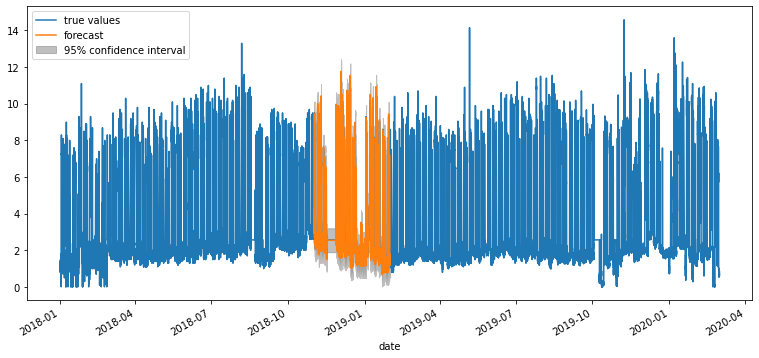

In [97]:

# Actual vs Fitte
fig, ax = plt.subplots(figsize=(13,6))

ax = energy_use[var].plot(label ='true values', ax=ax)

fig = plot_predict(sarimax_fit, start = start, end = end, ax = ax)
#ax.set_xlim(['2019-01', '2019-02'])
plt.legend()
plt.show()

Next, we will compare the MSE of both models:

In [98]:
metrics(sarimax_fit, df_test, df_train)

TRAIN SET METRICS
mae: 0.10912136778463861
mape: 0.03278537966949469
rmse: 0.20691686012463906
TEST SET METRICS
mae: 3.156950959954527
mape: 0.9912578358260837
rmse: 3.9959285011301193


### Prophet
We will try a very simple model and check if we still have overfitting:

In [11]:
from prophet import Prophet
df_train_pf = df_train_full.reset_index()
df_train_pf.columns=['ds', 'y']
df_test_pf = df_test_full.reset_index()
df_test_pf.columns=['ds', 'y']

In [12]:
model = Prophet()
model.fit(df_train_pf)

20:04:18 - cmdstanpy - INFO - Chain [1] start processing
20:04:34 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
#Out of sample forecast
future = df_test_pf[['ds']]
forecast = model.predict(future)

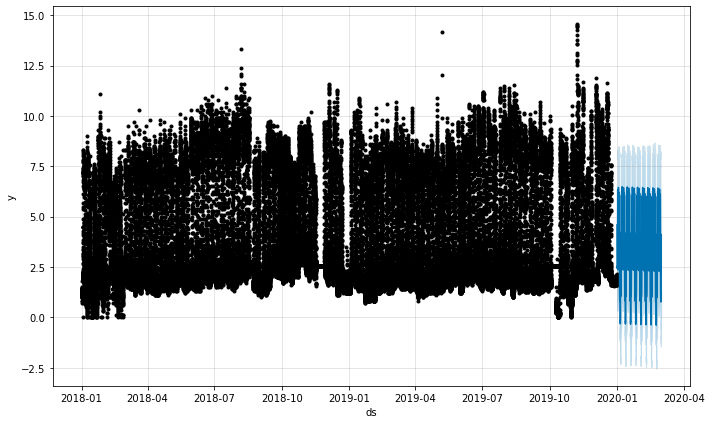

In [14]:
fig1 = model.plot(forecast)


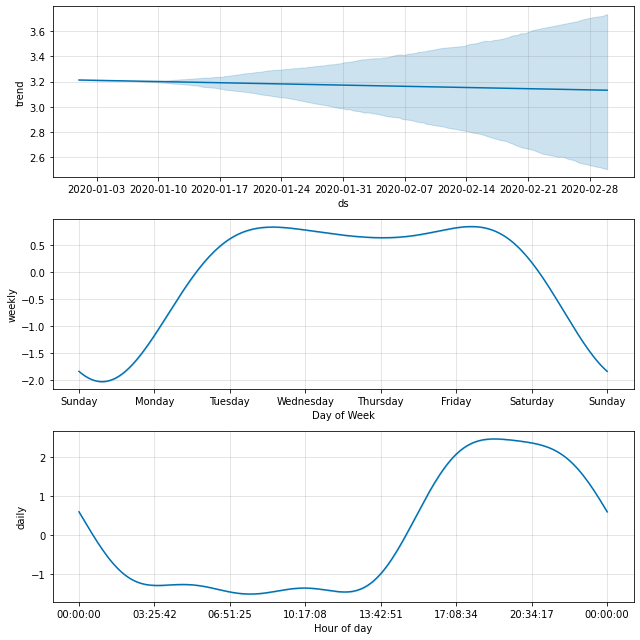

In [15]:
fig2 = model.plot_components(forecast)


In [16]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

Next, we will check the in sample predictions


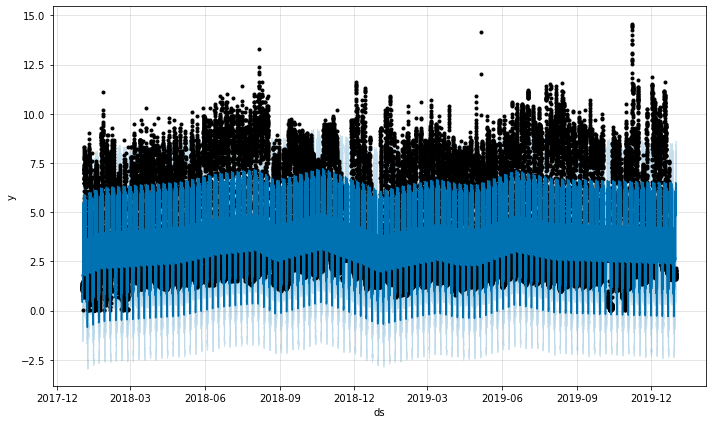

In [106]:
#Out of sample forecast
future = df_train_pf[['ds']]
forecast = model.predict(future)
fig1 = model.plot(forecast)


We see that it picks up some of the movement of the time series, but not really, since it doesn't model all the peaks.

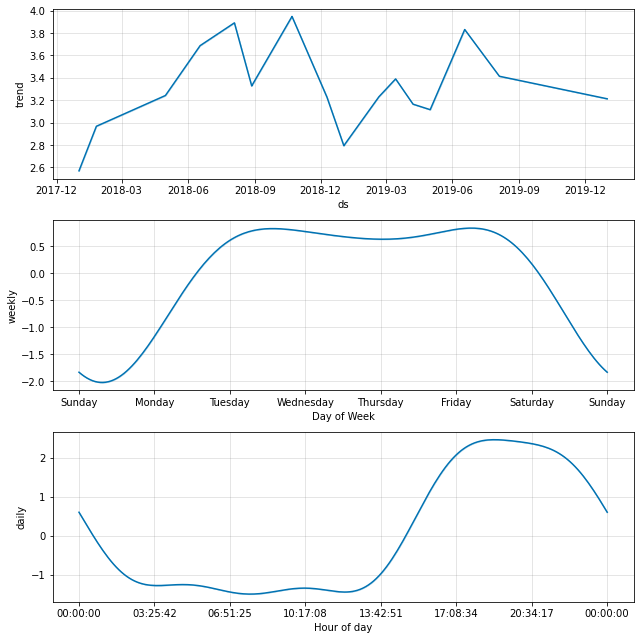

In [83]:
fig2 = model.plot_components(forecast)


Now we will repeat some of the plots we had with previous models, so we can compare them:


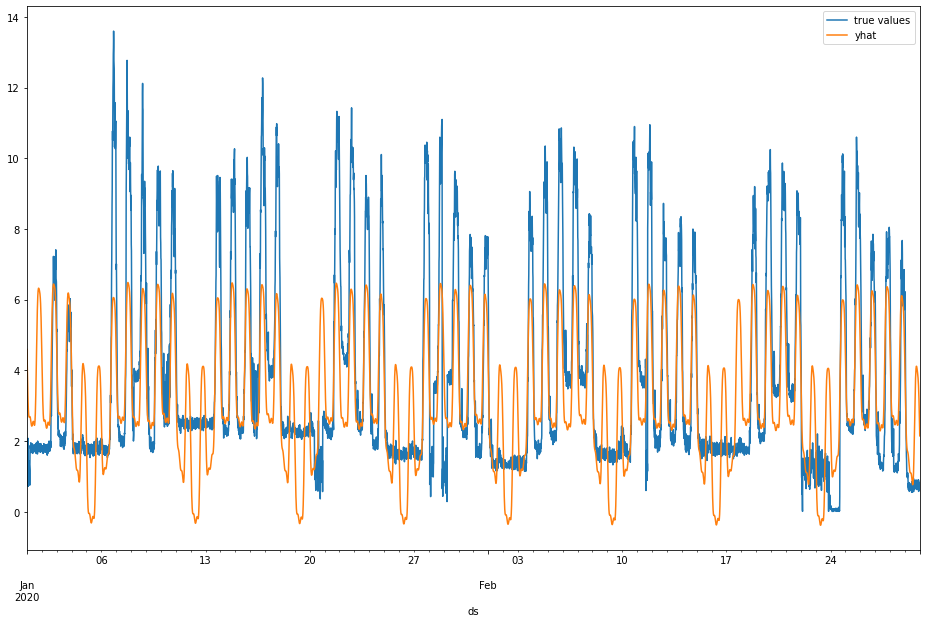

In [21]:
plt.figure(figsize=(16, 10))
df = energy_use
#Out of sample forecast
future = df_test_pf[['ds']]
forecast = model.predict(future)[['ds', 'yhat']].set_index('ds')
ax = df[df.index.year==2020][var].plot(label='true values')
forecast.plot(label='predicted values', ax=ax)
plt.legend()